# Importing Libraries

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as numpy
import pandas as pd

In [5]:
#To visualize the data in the project

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
import sklearn
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import TfidfVectorizer

NLP Preprocessing libraries

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [9]:
import re
import random
import gensim

In [10]:
from collections import Counter
import unicodedata as udata
import string

checking the versions 

In [11]:
print(sklearn.__version__)
print(matplotlib.__version__)
print(numpy.__version__)
print(pd.__version__)
print(nltk.__version__)

1.0.2
3.2.2
1.21.6
1.3.5
3.2.5


# Reading csv file

In [12]:
df = pd.read_csv("/content/gdrive/MyDrive/Project/TwitterSentimentAnalysis.csv", encoding='latin-1', header=None)

Shuffling the data in the data frame

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

# Give column names

Assigning the Columns name to the data

In [14]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"] 

In [15]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user', 'text'], dtype='object')

Checking Null values in the dataset. Here we are counting each cloumn null values in the data set

In [16]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

Checking the duplicates values and counting duplicates in the data set

In [17]:
df.duplicated().sum()

0

get the first 5 rows from the dataframe

In [18]:
df.head(5)

,sentiment,id,date,query,user,text
0,0,2183373231,Mon Jun 15 14:25:01 PDT 2009,NO_QUERY,RylinPhotog,@rachaelearl Me
1,0,2225142712,Thu Jun 18 10:21:50 PDT 2009,NO_QUERY,Emily_YA,Two separate clients called within minutes of...
2,4,1980071462,Sun May 31 05:35:02 PDT 2009,NO_QUERY,KOLtwitbot,"Thrincold: Tired but good, No more working at ..."
3,4,1978664063,Sun May 31 00:03:50 PDT 2009,NO_QUERY,alatariel1234,@poprocker85 Yeah it will go down a treat with...
4,4,1882077306,Fri May 22 06:11:05 PDT 2009,NO_QUERY,kaylanadeau,good morning! another beautiful day


drop some column from the dataframe 

In [19]:
df = df.drop(["id", "date", "query", "user"], axis = 1) 

In [20]:
df.head(5)

,sentiment,text
0,0,@rachaelearl Me
1,0,Two separate clients called within minutes of...
2,4,"Thrincold: Tired but good, No more working at ..."
3,4,@poprocker85 Yeah it will go down a treat with...
4,4,good morning! another beautiful day


 count the number of sentiments with respect to their tweet (4 stands for positive tweet and 0 stands for negative tweet)

In [21]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64












# Cleaning data

add new column pre_clean_len to dataframe which is length of each tweet

In [22]:
df['pre_clean_len'] = [len(t) for t in df.text]

Finding outliers using Box plot using pre_clean_len column

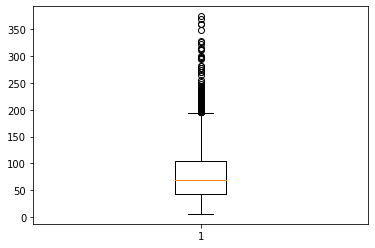

In [23]:
plt.boxplot(df.pre_clean_len)
plt.show()

check for any tweets greater than 140 characters

In [24]:
df[df.pre_clean_len > 140].head(10) 

,sentiment,text,pre_clean_len
118,4,cute: Camille told me that MS &quot;stole&quot...,145
124,0,It's 4pm &amp; I'm still in bed gotta get up &...,142
381,0,"My Dad, who is my medic, keeps telling me I'm ...",142
391,0,why can't american idol 9 auditions come to ph...,142
417,4,@Pokinatcha Thanks Every time I look at that ...,149
596,4,@Cuan been in meetings &amp; have just heard &...,144
617,4,@minimum12 Glad to hear it! I also wrote a 30...,148
768,0,OMG-BBQed rib rack last night. Went to icebox ...,142
791,0,@lizawhitten It's fathers day? Not here. ......,158
808,4,"@BertaWooster yeah, master Stephen has to &quo...",143


At this stage, if you want you could remove these outlier tweets

# Cleaning operations

In [25]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'        # remove @ mentions from tweets
pat2 = r'https?://[^ ]+'        # remove URLs from tweets
combined_pat = r'|'.join((pat1, pat2)) #addition of pat1 and pat2
www_pat = r'www.[^ ]+'         # remove URLs from tweets
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   # converting words like isn't to is not
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):  # define tweet_cleaner function to clean the tweets
    soup = BeautifulSoup(text, 'lxml')    # create beautiful soup object
    souped = soup.get_text()   # get only text from the tweets 
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")    # remove utf-8-sig code
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed) # calling combined_pat
    stripped = re.sub(www_pat, '', stripped) #remove URLs
    lower_case = stripped.lower()      # converting all into lower case
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case) # converting words like isn't to is not
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)       # will replace # by space
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1] # Word Punct Tokenize and only consider words whose length is greater than 1
    return (" ".join(words)).strip() # join the words

In [26]:
#Note that we have 1600000 instances. But processing so many instances will take a very very long time.
#Hence, restricting to rather 50000 instances.
limit= 1600000
import time; 
ms = time.time()
#nums = [0,400000,800000,1200000,1600000] # used for batch processing tweets
#nums = [0, 9999]
clean_tweet_texts = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    if i % 10000==0:
        print(i, time.time()-ms)
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  # call tweet_cleaner function and pass parameter as all the tweets to clean the tweets and append cleaned tweets into clean_tweet_texts list

0 0.000118255615234375
10000 2.1623737812042236
20000 4.341637372970581
30000 6.563189268112183
40000 8.712594270706177
50000 10.88085412979126
60000 13.041598796844482
70000 15.183896541595459
80000 17.337077856063843
90000 19.523456573486328
100000 21.677738189697266
110000 24.254932165145874
120000 26.666531801223755
130000 28.824955701828003
140000 31.01118540763855
150000 33.303027868270874
160000 35.45342993736267
170000 37.63567566871643
180000 39.759355306625366
190000 41.91811203956604
200000 44.05707383155823
210000 46.18700957298279
220000 48.349573850631714
230000 50.48068714141846
240000 52.61353373527527
250000 54.739397287368774
260000 56.86783456802368
270000 59.38341736793518
280000 61.520893812179565
290000 63.65653967857361
300000 65.7738401889801
310000 67.93718838691711
320000 70.06139969825745
330000 72.20180225372314
340000 74.45331120491028
350000 76.63723707199097
360000 78.8369631767273
370000 81.09071135520935
380000 83.3347373008728
390000 85.54621696472168


# clean_tweet_texts

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

tokenize word in clean_tweet_texts and append it to word_tokens list

In [28]:
word_tokens = [] # initialize list for tokens
for word in clean_tweet_texts:  # for each word in clean_tweet_texts
    word_tokens.append(word_tokenize(word)) #tokenize word in clean_tweet_texts and append it to word_tokens list

# Lemmatizing

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [30]:
df1 = [] # initialize list df1 to store words after lemmatization
from nltk.stem import WordNetLemmatizer # import WordNetLemmatizer from nltk.stem
lemmatizer = WordNetLemmatizer() # create an object of WordNetLemmatizer
for l in word_tokens: # for loop for every tokens in word_token
    b = [lemmatizer.lemmatize(q) for q in l] #for every tokens in word_token lemmatize word and giev it to b
    df1.append(b) #append b to list df1

# df

In [31]:
clean_df1 =[] # initialize list clean_df1 to join word tokens after lemmatization
for c in df1:  # for loop for each list in df1
    a = " ".join(c) # join words in list with space in between and give it to a
    clean_df1.append(a) # append a to clean_df1

# clean_df1

convert clean_tweet_texts into dataframe and name it as clean_df

In [32]:
clean_df = pd.DataFrame(clean_df1,columns=['text']) # convert clean_tweet_texts into dataframe and name it as clean_df
#clean_df['target'] = df.sentiment[:10000] # from earlier dataframe get the sentiments of each tweet and make a new column in clean_df as target and give it all the sentiment score
#clean_df

In [33]:
clean_df['clean_len'] = [len(t) for t in clean_df.text] # Again make a new coloumn in the dataframe and name it as clean_len which 

In [34]:
clean_df[clean_df.clean_len > 140].head(10) # again check if any tweet is more than 140 characters

,text,clean_len


In [35]:
target2 = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    target2.append(df['sentiment'][i])
clean_df['target']=target2
df.head()

,sentiment,text,pre_clean_len
0,0,@rachaelearl Me,17
1,0,Two separate clients called within minutes of...,138
2,4,"Thrincold: Tired but good, No more working at ...",73
3,4,@poprocker85 Yeah it will go down a treat with...,64
4,4,good morning! another beautiful day,36


In [36]:
X = clean_df.text # get all the text in x variable
y = clean_df.target # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y
from collections import Counter
print(set(y)) # equals to list(set(words))
print(Counter(y).values()) #

(1600000,)
(1600000,)
{0, 4}
dict_values([800000, 800000])


# perform train and test split

X_train is the tweets of training data, X_test is the testing tweets which we have to predict, y_train is the sentiments of tweets in the traing data and y_test is the sentiments of the tweets  which we will use to measure the accuracy of the model

In [37]:
from sklearn.model_selection  import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [38]:
y_train = [x if x==0 else 1 for x in y_train.tolist()]
y_test = [x if x==0 else 1 for x in y_test.tolist()]
X_train = X_train.tolist()
X_test = X_test.tolist()

In [39]:
import numpy as np
X_train= np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [40]:
#TF-IDF algoerithm
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer  = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))
vectorizer.fit(X_train)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Naive Bayes Algorithm

In [41]:
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
model_naive = MultinomialNB() 
model_naive.fit(X_train_tfidf, y_train)

MultinomialNB()

In [42]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = model_naive, X = X_train_tfidf, y = y_train, cv = 10) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.80633046875

In [43]:
pred_nb = model_naive.predict(X_test_tfidf) 

In [44]:
#Accuracy
from sklearn import metrics # import metrics from sklearn
metrics.accuracy_score(y_test, pred_nb) 

0.8067625

In [45]:
#Confucion matrix
from sklearn.metrics import classification_report,confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, pred_nb)

array([[136467,  23802],
       [ 38034, 121697]])

In [46]:
#classification report
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82    160269
           1       0.84      0.76      0.80    159731

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [47]:

import pickle
pickle.dump(vectorizer, open("tfidf1.pickle", "wb"))

In [48]:
#Save Niave Base algorithm
import pickle
pickle.dump(model_naive, open("naive.pickle", "wb"))

# Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression # import Logistic Regression model from sklearn.linear_model
logisticRegression = LogisticRegression(solver='lbfgs',max_iter=1000)

In [50]:
#Train the logistic regresion
lg_model = logisticRegression.fit(X_train_tfidf, y_train)

In [51]:
#Testing prdc=iction
pred_lg = lg_model.predict(X_test_tfidf) 

In [52]:
#confysion matrix
confusion_matrix(y_test, pred_lg)

array([[133941,  26328],
       [ 29962, 129769]])

In [53]:
print(classification_report(pred_lg, y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83    163903
           1       0.81      0.83      0.82    156097

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



In [54]:
#save Logistic Regression model
pickle.dump(lg_model, open("lg_model.pickle", "wb"))

# Support Vector Machine 

In [55]:
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
svm = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [56]:
#SVM train
svm_model = svm.fit(X_train_tfidf, y_train)

In [57]:
#Prediction
y_pred_svm = svm_model.predict(X_test_tfidf)

In [58]:
#confysion matrix
confusion_matrix(y_pred_svm, y_test)

array([[134114,  29615],
       [ 26155, 130116]])

In [59]:
#Classification report
print(classification_report(y_pred_svm, y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83    163729
           1       0.81      0.83      0.82    156271

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



In [60]:
#save Logistic Regression model
pickle.dump(svm_model, open("svm_model.pickle", "wb"))

**Decision Tree**

In [61]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 100, max_depth=3, min_samples_leaf=5) 

In [62]:
#Train the Decicion tree
dtc.fit(X_train_tfidf, y_train) 

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=100)

In [63]:
#Prediction
y_pred_dtc = dtc.predict(X_test_tfidf)

In [64]:
#confysion matrix
confusion_matrix(y_pred_dtc, y_test)

array([[ 40976,  15212],
       [119293, 144519]])

In [65]:
#Classification report
print(classification_report(y_pred_dtc, y_test))

              precision    recall  f1-score   support

           0       0.26      0.73      0.38     56188
           1       0.90      0.55      0.68    263812

    accuracy                           0.58    320000
   macro avg       0.58      0.64      0.53    320000
weighted avg       0.79      0.58      0.63    320000



 ## Ensemble method

In [68]:
from sklearn.ensemble import VotingClassifier


In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
model_1 = LogisticRegression(solver='lbfgs',max_iter=1000)
model_2 = MultinomialNB() 
model_3 = LinearSVC(random_state=0)
# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('lg', model_1), ('mnb', model_2), ('Lsvm', model_3)], voting='hard')
# training all the model on the train dataset
final_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('lg', LogisticRegression(max_iter=1000)),
                             ('mnb', MultinomialNB()),
                             ('Lsvm', LinearSVC(random_state=0))])

In [70]:
# predicting the output on the test dataset
pred_final = final_model.predict(X_test_tfidf)

In [71]:
#confysion matrix
from sklearn.metrics import classification_report,confusion_matrix 
confusion_matrix(pred_final, y_test)

array([[135603,  30893],
       [ 24666, 128838]])

In [72]:
#Classification report
print(classification_report(pred_final, y_test))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83    166496
           1       0.81      0.84      0.82    153504

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000

